**Importing the Liibraries**

In [36]:
# loading the dataset
import os
from os import listdir
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from shutil import copyfile

from torch.utils.data import Dataset
import torch.optim as optim

import cv2
from skimage import io 
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt


**Data Preprocessing for the Model**
*   The Encoder Decoder will produce the binary mask images. Binary mask images cannot be compared with the annotation images given in the dataset. So, a contour filling algorithm is used to generate massked images from the annotation images and the file is saved. This will be used as label for training the model later on. (This was done in jupyter notebook.: screenshots attatched.)



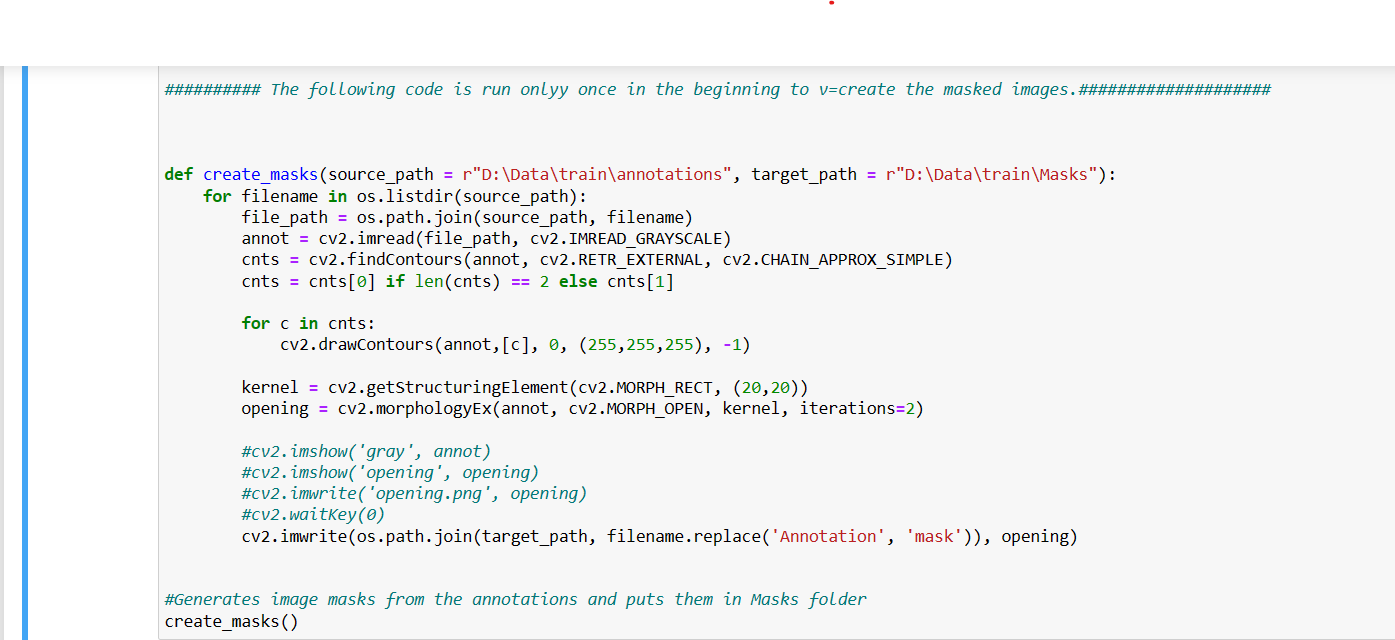

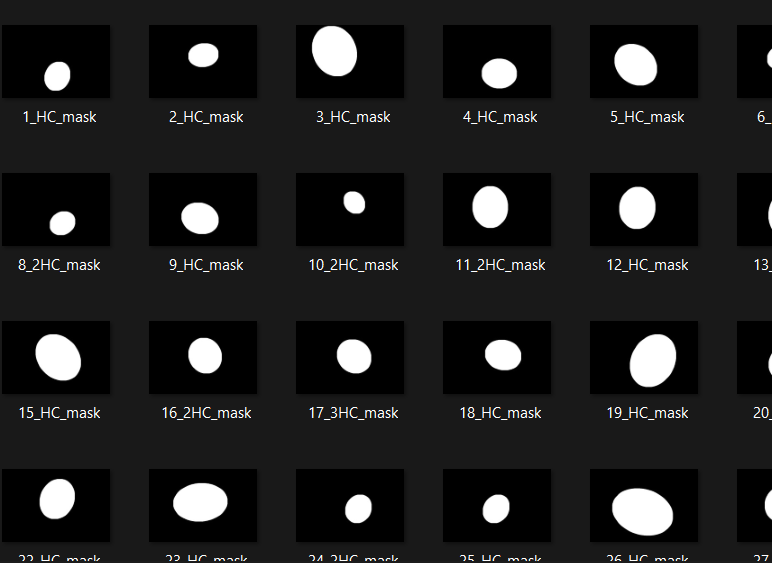












The preapared data was uploaded to kaggle and used from there.

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amarchandc/data-foetus
!unzip data-foetus.zip

**Calculating the mean and std deviation of image data**

**Transformation Aplied to the images**

In [6]:
transform = transforms.Compose([transforms.Resize((448, 448)),transforms.ToTensor(),transforms.Normalize((0.15), (0.17))])

In [7]:
image_folder = "/content/train/images"               #destination_folder_images
mask_folder = "/content/train/Masks"               #destination_folder_masks

class ImageDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=transform):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_folder))
        #self.mask_filenames = os.listdir(mask_folder)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_folder, image_filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = Image.open(image_path)
        
        # load mask label
        mask_filename = image_filename.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_folder, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = Image.open(mask_path)
    

       # apply transform
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)


        return image, mask

**The Encoder Decoder Network is designed**


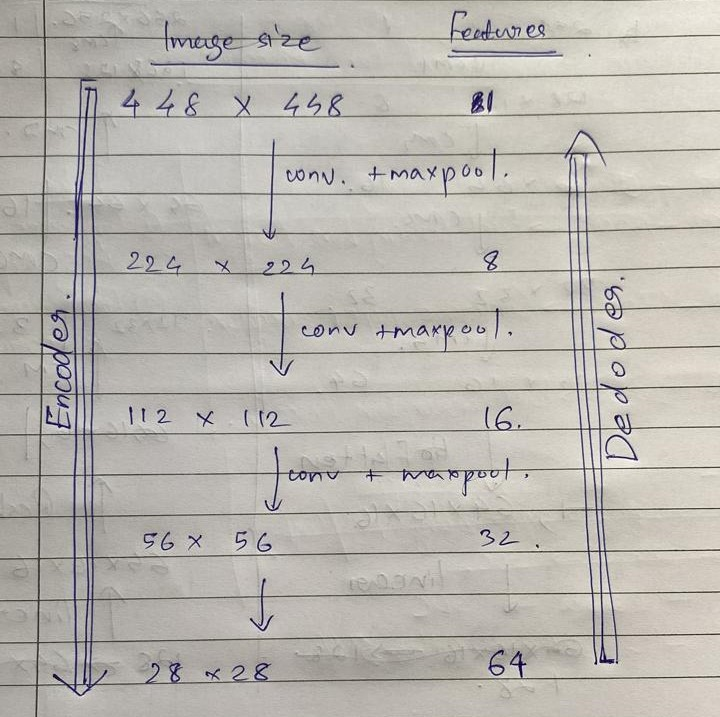

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # input channel 1, output channel 64, kernel size 3
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        # self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1) 
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.fc1 = nn.Linear(64*28*28, 128)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # apply conv layer with ReLU activation
        x = self.maxpool(x)  # apply max pooling        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)       
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)

        # x = F.relu(self.conv5(x))
        # x = self.maxpool(x)
        
        # x = F.relu(self.conv6(x))
        # x = self.maxpool(x)
        
        x = x.view(-1, 64*28*28)
        x = self.fc1(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.conv7 = nn.ConvTranspose2d(256,128, kernel_size=3, padding=1)  # input channel 512, output channel 256, kernel size 3
        # self.conv8 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)  # input channel 256, output channel 128, kernel size 3
        self.conv9 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)  # input channel 512, output channel 256, kernel size 3
        self.conv10 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)  # input channel 256, output channel 128, kernel size 3
        self.conv11= nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1)  # input channel 128, output channel 64, kernel size 3
        self.conv12 = nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1)  # input channel 64, output channel 1, kernel size 3
        
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.fc2   =  nn.Linear(128, 64*28*28)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding = 0)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc2(x)
        x = x.view(-1, 64, 28, 28)        
        
        # x = F.relu(self.conv7(x))
        # x = self.up(x)

        # x = F.relu(self.conv8(x))
        # x = self.up(x)
        
        x = F.relu(self.conv9(x))
        x = self.up(x)
        
        x = F.relu(self.conv10(x))
        x = self.up(x)
        
        x = F.relu(self.conv11(x))
        x = self.up(x)
             
        x = F.relu(self.conv12(x))
        x = self.up(x)

        x = self.sigmoid(x)
        return x

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


**Dice Coefficient was Defined**

In [9]:
def dice_coefficient(pred, target):
    smooth = 1.0
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)

class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        loss = 1 - dice_coefficient(pred, target)
        return loss

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = EncoderDecoder()
batch_size = 15
#Train_Dataset =ImageDataset(r"C:\Users\LENOVO\OneDrive - IIT-Madras(IC&SR)\Courses\ID 5030\A6\Data\training_set", transform = transform)
Train_Dataset =ImageDataset(image_folder, mask_folder, transform = transform)
dataloader = torch.utils.data.DataLoader(Train_Dataset, batch_size, shuffle =True)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10

**Training the Model**

In [38]:
for epoch in range(num_epochs):
    for i, (image, mask) in enumerate(dataloader):
        # move the inputs to the GPU if available
        if torch.cuda.is_available():
            image = image.cuda()
            mask = mask.cuda()
            model = model.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(image)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()



        # print statistics
        if i % 15 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(Train_Dataset)//batch_size, loss.item()))


Epoch [1/10], Step [1/66], Loss: 0.2373
Epoch [1/10], Step [16/66], Loss: -0.3704
Epoch [1/10], Step [31/66], Loss: -0.3448
Epoch [1/10], Step [46/66], Loss: -0.2558
Epoch [1/10], Step [61/66], Loss: -0.3481
Epoch [2/10], Step [1/66], Loss: -0.3238
Epoch [2/10], Step [16/66], Loss: -0.3556
Epoch [2/10], Step [31/66], Loss: -0.4263
Epoch [2/10], Step [46/66], Loss: -0.3824
Epoch [2/10], Step [61/66], Loss: -0.4617
Epoch [3/10], Step [1/66], Loss: -0.4876
Epoch [3/10], Step [16/66], Loss: -0.5273
Epoch [3/10], Step [31/66], Loss: -0.4819
Epoch [3/10], Step [46/66], Loss: -0.4052
Epoch [3/10], Step [61/66], Loss: -0.4846
Epoch [4/10], Step [1/66], Loss: -0.3964
Epoch [4/10], Step [16/66], Loss: -0.4517
Epoch [4/10], Step [31/66], Loss: -0.4792
Epoch [4/10], Step [46/66], Loss: -0.5298
Epoch [4/10], Step [61/66], Loss: -0.3820
Epoch [5/10], Step [1/66], Loss: -0.4592
Epoch [5/10], Step [16/66], Loss: -0.4609
Epoch [5/10], Step [31/66], Loss: -0.4667
Epoch [5/10], Step [46/66], Loss: -0.481

In [39]:
#### saving the model

PATH = "/content/Saved_Model.pth"

# save the model state dictionary and the optimizer state dictionary
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

################### To load the model ##################

# PATH = "model.pth"

# # load the saved model state dictionary and optimizer state dictionary
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # put the model in evaluation mode (if needed)
# model.eval()

**Testing the model on Test Dataset**

In [40]:
class TestDataset(Dataset):
    def __init__(self, test_folder, transform=transform):
        self.test_folder = test_folder
        self.transform = transform
        data_paths = [os.path.join(self.test_folder, f) for f in sorted(os.listdir(self.test_folder))]
        self.test_filenames = [i for i in data_paths if os.path.isfile(i)]        
        
        #self.test_filenames = os.listdir(test_folder)
    
    def __len__(self):
        return len(self.test_filenames)  
    
    def __getitem__(self, idx):
        test_filename = self.test_filenames[idx]
        test_path = os.path.join(self.test_folder, test_filename)
        #img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
        image_test = Image.open(test_path)


       # apply transform
        if self.transform is not None:
            image_test = self.transform(image_test)


        return image_test

In [41]:

# set the model to evaluation mode
model.eval()

# create a dataloader for the test dataset
Test_Dataset =TestDataset('/content/test_set', transform = transform)
test_dataloader = torch.utils.data.DataLoader(Test_Dataset, batch_size=1, shuffle =False)


# create a list to store the predicted masks
pred_masks = []

# disable autograd to speed up the inference
with torch.no_grad():
    # loop through the test dataloader
    for image in test_dataloader:
        # move the inputs to the GPU if available
        if torch.cuda.is_available():
           image = image.cuda()

        # forward pass
        output = model(image)
        # apply softmax to convert the output into probabilities
        #output = torch.sigmoid(output)


        # convert the tensors to numpy arrays and append to the list
        pred_masks.append((output.cpu().numpy()>0.8).astype(np.uint8))




**Testing the model for test data. For that, draw_boundary function is used**.
**The working of this function is also checked below.**

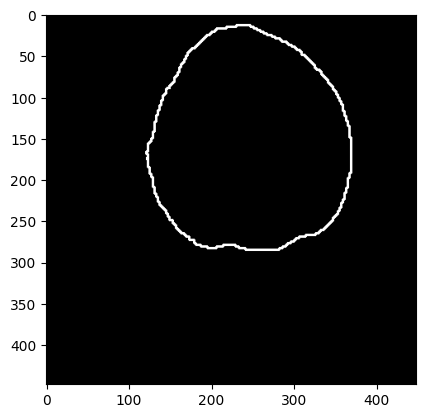

In [42]:
def draw_boundary(mask_image):
    # Apply Canny edge detection to extract the object boundary
    canny_edges = cv2.Canny(mask_image, threshold1=0, threshold2=1)
    # Dilate the edges to fill in the object boundary
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(canny_edges, kernel, iterations=1)
    # Invert the mask to get the object mask
    object_mask = 1 - dilated_edges
    # Convert the NumPy array to a PyTorch tensor
    annot = torch.from_numpy(object_mask).float()

    return annot
masked = pred_masks[25][0][0]

annotation =  draw_boundary(masked)

plt.figure;
plt.imshow(annotation, 'gray')
plt.show()






**Saving the outputs created**

In [49]:
# now we have to save both files into the respective folders.
output_annot_folder = '/content/test_annot'
output_mask_folder = '/content/test_masks'


if not os.path.exists('/content/test_annot'):
    os.makedirs('/content/test_annot')

if not os.path.exists('/content/test_mask'):
    os.makedirs('/content/test_mask')

PATH = '/content/Saved_Model.pth'

# load the saved model state dictionary and optimizer state dictionary
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# put the model in evaluation mode (if needed)
model.eval()


test_image_folder = '/content/test_set'

# Set the path to the folder where you want to save the predicted output images
output_folder = '/content/test_annot'

# Loop through each test image in the folder
for image_name in sorted(os.listdir(test_image_folder)):
    # Load the image and convert it to a PyTorch tensor
    image = Image.open(os.path.join(test_image_folder, image_name))
    image_tensor = transform(image)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
        
    # Make a prediction on the input image
    with torch.no_grad():
        masked1= model(image_tensor)  ### maask outputs.
        masked2 = masked1[0][0].cpu().numpy() 
        #img_mask = Image.fromarray(masked2)
        masked3 = cv2.convertScaleAbs(masked2)
        annot_img  = draw_boundary(masked3)   ### Annotation generated.
        annot_file_name = image_name.replace('.png', '_op_annot.png')
        file_path_annot = os.path.join(output_annot_folder, annot_file_name)
        #file_path_mask = os.path.join(output_mask_folder, mask_file_name)
        img_array1 = annot_img.numpy()
        annot = Image.fromarray(np.uint8(img_array1))

        annot.save(file_path_annot)






**The model functioning is checked here. The overlayed images images are generated to show the annotation on the original image itself.**

**Generating the Overlayed image from the annotation and original test images.**

In [60]:
def Output_fun(input_image_path, output_contour_path):
    from skimage import draw
    from skimage.color import gray2rgb

    img_array = np.array(Image.open(input_image_path).resize((448, 448)))
    contour_array = np.array(Image.open(output_contour_path))*255

    mask_array = np.zeros_like(img_array)
    white_pixels = np.where(contour_array == 255)

    # print the x and y coordinates of the white pixels
    y_coords = []
    x_coords = []
    for y, x in zip(*white_pixels):
        y_coords.append(y)
        x_coords.append(x)    

    mask_array[y_coords, x_coords] = 1

    green_mask = gray2rgb(mask_array)
    green_mask = np.where(green_mask > 0, [0, 0, 0], [0, 0, 255])
    img_array = gray2rgb(img_array)
    overlayed_image = img_array +(green_mask) 
   
    # display the overlayed image
    plt.imshow(overlayed_image)
    plt.show()
    #return overlayed_image

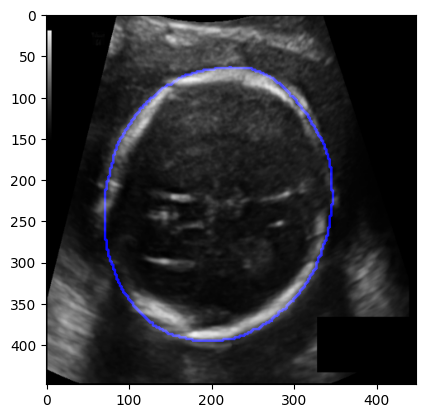

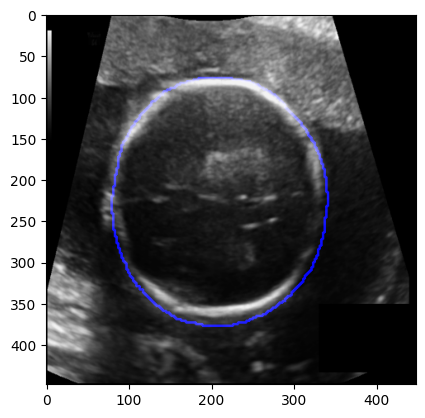

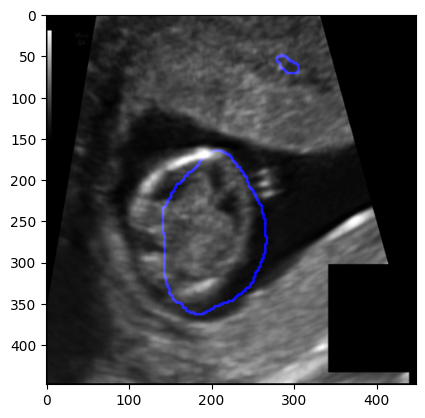

In [61]:
Output_fun('/content/test_set/103_HC.png', '/content/test_annot/103_HC_op_annot.png')
Output_fun('/content/test_set/12_HC.png', '/content/test_annot/12_HC_op_annot.png')
Output_fun('/content/test_set/149_2HC.png', '/content/test_annot/149_2HC_op_annot.png')

